In [1]:
# all codes come are changed based on LDR code.
import argparse
import torch.optim as optim
import os
import yaml
from mcrgan.default import _C as config
from mcrgan.default import update_config
import torch
from mcrgan.trainer import MCRTrainer
from mcrgan.datasets import get_dataloader
from mcrgan.models import get_models
from mcrgan.models import get_BNN_models
from mcrgan.models import get_noise
from mcrgan.models import DiscriminatorMNIST
from mcrgan.models import weights_init_mnist_model_noise

import numpy as np
import torch
import argparse
from mcrgan.datasets import get_dataloader
from mcrgan.models import get_models
from mcrgan.default import _C as config
from mcrgan.default import update_config
from utils.utils import sort_dataset, compute_accuracy, extract_features
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm
import os
from mcrgan.loss import MCRGANloss
import random
random.seed(0)

In [2]:
# data_preprocessing and parameters

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
DATASET = 'FMNIST'
ROOT    = 'pth/to/the/dataset'
BATCH_SIZE = 2048
WORKERS = 0
DATA_SAMPLE = 50000
LABEL = 4

dataloader, dataset = get_dataloader(
        data_name=DATASET,
        root=ROOT,
        batch_size=BATCH_SIZE,
        num_workers=WORKERS)


In [3]:
import collections

def get_netG(netD,netV,net_noise,radius=1):
    models = [netD, netV,net_noise]
    worker_state_dict = [x.state_dict() for x in models]
    weight_keys = list(worker_state_dict[0].keys())
    fed_state_dict = collections.OrderedDict()
    for key in weight_keys:
        fed_state_dict[key] = worker_state_dict[0][key] + radius*worker_state_dict[2][key]*torch.log(1+torch.exp(worker_state_dict[1][key]))
    return fed_state_dict

# new netG already optimized by adam and time learning rate, so we only using netG to update netV
def update_netV(netV,netG,net_noise,fed_state_dict,radius=1):
    models =[netV,netG,net_noise]
    worker_state_dict = [x.state_dict() for x in models]
    weight_keys = list(worker_state_dict[0].keys())
    update_dict = collections.OrderedDict()
    for key in weight_keys:
        update_dict[key] = worker_state_dict[0][key] - (worker_state_dict[1][key]-fed_state_dict[key])*(worker_state_dict[2][key]*radius)/torch.log(1+torch.exp(-worker_state_dict[0][key]))
    return update_dict
        

In [4]:
#models
# train hyperparameters, batch norm not used var
#store_Var = []
import time
from torch_mimicry.training import scheduler, logger, metric_log

from test_acc import nearsub
import numpy as np
import torch
import argparse
from mcrgan.datasets import get_dataloader
from mcrgan.models import get_models
from mcrgan.default import _C as config
from mcrgan.default import update_config
from utils.utils import sort_dataset, compute_accuracy, extract_features2
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm
import os

start_time = time.time()
#global_step = 0
num_steps = 150
n_dis = 1
n_dis2 = 1
numclasses =10
lr1 = 1e-3
lr2 = 1e-3
log_data = metric_log.MetricLog()
data_time = time.time()
iter_dataloader = iter(dataloader)
data, label = next(iter_dataloader)
data_time = time.time() - data_time
real_cpu = data.to(device)
real_label = label.clone().detach()

netD, netG, netV = get_BNN_models(DATASET, device, LABEL)
net_noise = get_noise(DATASET, device, LABEL)
fed_state_dict = get_netG(netD,netV,net_noise)
netG.load_state_dict(fed_state_dict)
optD = optim.Adam(netD.parameters(), lr1, betas=(0.5, 0.999))
optG = optim.Adam(netG.parameters(), lr2, betas=(0.5, 0.999))

Acc_results_D = []
Acc_results_G = []




transform = transforms.Compose(
            [transforms.Resize(32),
             transforms.ToTensor(),
             transforms.Normalize(0.5, 0.5)])

trainset = datasets.FashionMNIST(root=ROOT, train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root=ROOT, train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(
        testset, batch_size=DATA_SAMPLE, shuffle=False, num_workers=WORKERS)

trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=DATA_SAMPLE, shuffle=False, num_workers=WORKERS)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
n_comp = 10


In [5]:
netD, netG, netV

(DataParallel(
   (module): DiscriminatorMNIST_nzBN(
     (main): Sequential(
       (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): LeakyReLU(negative_slope=0.2, inplace=True)
       (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (4): LeakyReLU(negative_slope=0.2, inplace=True)
       (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (7): LeakyReLU(negative_slope=0.2, inplace=True)
       (8): Conv2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (9): Flatten(start_dim=1, end_dim=-1)
     )
   )
 ),
 DataParallel(
   (module): DiscriminatorMNIST_nzBN(
     (main): Sequential(
       (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [6]:
net_noise

DataParallel(
  (module): DiscriminatorMNIST_nzBN(
    (main): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (9): Flatten(start_dim=1, end_dim=-1)
    )
  )
)

In [7]:
# golden search algorithm to determined the radius of the sample ball, due to traditional updating netV is too slow
# no meaning for n_dis =2 for our case, just to have output for every update
# sample too much would arise cuda memory error
def gs_radius(radius1,radius2,netD,real_cpu,real_label,tor=1e-3,n_dis=2,lam=0.618,mode=1,gam3=1):
    mcr_gan_loss=MCRGANloss(gam1=1., gam2=1., gam3=gam3, eps=0.5, numclasses=numclasses, mode=mode, rho=None)
    #optG = optim.Adam(netG.parameters(), lr2, betas=(0.5, 0.999))
    
    Z = netD(real_cpu)
    net_noise = get_noise(DATASET, device, LABEL)
    err1 = 0
    err2 = 1000
    while abs(err1 - err2)> tor or abs(radius1-radius2)>tor:
        a1 = radius2 - lam*(radius2-radius1)
        a2 = radius1 + lam*(radius2-radius1)
        fed_state_dict = get_netG(netD,netV,net_noise,a1)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errG1, errG_EC1 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
        err1 = errG1
        
        fed_state_dict = get_netG(netD,netV,net_noise,a2)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errG2, errG_EC2 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
        err2 = errG2
        
        if err1 > err2:
            radius1 = a1
            a1 = a2
            err1 = err2
            a2 = radius1 + lam*(radius2-radius1)
            fed_state_dict = get_netG(netD,netV,net_noise,a2)
            netG.load_state_dict(fed_state_dict)
            Z_bar = netG(real_cpu)
            errG2, errG_EC2 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
            err2 = errG2
            #print('r1',radius1)
            #print(errG2, errG_EC2)
        else:
            radius2 = a2
            a2 = a1
            a1 = radius2 - lam*(radius2-radius1)
            fed_state_dict = get_netG(netD,netV,net_noise,a1)
            netG.load_state_dict(fed_state_dict)
            Z_bar = netG(real_cpu)
            errG1, errG_EC1 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
            err1 = errG1
            #print('r2',radius2)
            #print(errG1, errG_EC1)
         
    return radius1,radius2

In [8]:
# Use Grid search to check if the large value radius is valid or not. Does the function only have one minimum point?
# Because we don't see pretty small value under enough dimension case, hence we check the radius level from 0-20 with 0.05 by 
# Grid Search, because we can see radius up to 10 has come to random guess
def gs_radius_And_GridSearch(radius1,radius2,netD,real_cpu,real_label,tor=1e-3,n_dis=2,lam=0.618,mode=1,gam3=1):
    mcr_gan_loss=MCRGANloss(gam1=1., gam2=1., gam3=gam3, eps=0.5, numclasses=numclasses, mode=mode, rho=None)
    #optG = optim.Adam(netG.parameters(), lr2, betas=(0.5, 0.999))
    
    Z = netD(real_cpu)
    net_noise = get_noise(DATASET, device, LABEL)
    err1 = 0
    err2 = 1000
    while abs(err1 - err2)> tor or abs(radius1-radius2)>tor:
        a1 = radius2 - lam*(radius2-radius1)
        a2 = radius1 + lam*(radius2-radius1)
        fed_state_dict = get_netG(netD,netV,net_noise,a1)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errG1, errG_EC1 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
        err1 = errG1
        
        fed_state_dict = get_netG(netD,netV,net_noise,a2)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errG2, errG_EC2 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
        err2 = errG2
        
        if err1 > err2:
            radius1 = a1
            a1 = a2
            err1 = err2
            a2 = radius1 + lam*(radius2-radius1)
            fed_state_dict = get_netG(netD,netV,net_noise,a2)
            netG.load_state_dict(fed_state_dict)
            Z_bar = netG(real_cpu)
            errG2, errG_EC2 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
            err2 = errG2
            #print('r1',radius1)
            #print(errG2, errG_EC2)
        else:
            radius2 = a2
            a2 = a1
            a1 = radius2 - lam*(radius2-radius1)
            fed_state_dict = get_netG(netD,netV,net_noise,a1)
            netG.load_state_dict(fed_state_dict)
            Z_bar = netG(real_cpu)
            errG1, errG_EC1 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
            err1 = errG1
            #print('r2',radius2)
            #print(errG1, errG_EC1)
            
        # Grid Search case, 100 points on 0-0.1,0.1-10, 10-100    
        radius_gs = 0
        value_gs = np.zeros([1,300])
        errG3, errG_EC3 = mcr_gan_loss(Z, Z, real_label, n_dis2 - 1, n_dis2)
        value_gs[0][0] = errG3
        err_Grid = errG3
        
        # to check the small radius when dimension is not enough
        for _ in range(295):
            if _ < 100:
                radius_temp = (_ + 1)*0.001
            elif _ < 200:
                radius_temp = 0.1 + (_ - 100)*0.1
            else:
                radius_temp = 11 + (_ - 200)*1

            fed_state_dict = get_netG(netD,netV,net_noise,radius_temp)
            netG.load_state_dict(fed_state_dict)
            Z_bar = netG(real_cpu)
            errG3, errG_EC3 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
            value_gs[0][_+ 1] = errG3
            err_temp = errG3
            
            if err_temp < err_Grid:
                radius_gs = radius_temp
                err_Grid  = err_temp
                
         
    return radius1,radius2, radius_gs, value_gs

In [9]:
# fixed radius case, due to this requires more steps to go to about -200 then set 1500 epoches
mean_V = []
n_dis2 = 1
n_dis = 1
mode = 11
gam3 = 1
mcr_gan_loss = MCRGANloss(gam1=1., gam2=1., gam3=gam3, eps=0.5, numclasses=numclasses, mode=mode, rho=None)
loss_V = 0
last_V = -1000
num_steps = 1000
lr1 = 1e-3
lr2 = 1e-3
optD = optim.Adam(netD.parameters(), lr1, betas=(0.5, 0.999))
optG = optim.Adam(netG.parameters(), lr2, betas=(0.5, 0.999))
meanV_sum = []
radius_list = []
radius = 0
for epoch in range(num_steps):

    for i in range(n_dis):
        netD.zero_grad()
        optD.zero_grad()
        Z = netD(real_cpu)
        net_noise = get_noise(DATASET, device, LABEL)
        #radius,_ = gs_radius(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
        #radius_list.append(radius)
        #print(radius)
        fed_state_dict = get_netG(netD,netV,net_noise,radius)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errD, errD_EC = mcr_gan_loss(Z, Z_bar, real_label, 1, n_dis)
        print(errD, errD_EC)
        errD.backward()
        optD.step()

    #print(meanV_num)
    #print(tempV)
    
    

tensor(-17.2806, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-8.6403, device='cuda:0', grad_fn=<NegBackward0>), tensor(-8.6403, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-12.2211, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-6.1106, device='cuda:0', grad_fn=<NegBackward0>), tensor(-6.1106, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-22.6811, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-11.3406, device='cuda:0', grad_fn=<NegBackward0>), tensor(-11.3406, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-27.4340, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-13.7170, device='cuda:0', grad_fn=<NegBackward0>), tensor(-13.7170, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-28.3041, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-14.1520, 

tensor(-59.0640, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-29.5320, device='cuda:0', grad_fn=<NegBackward0>), tensor(-29.5320, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-59.9354, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-29.9677, device='cuda:0', grad_fn=<NegBackward0>), tensor(-29.9677, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-61.3655, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-30.6827, device='cuda:0', grad_fn=<NegBackward0>), tensor(-30.6827, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-62.3305, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-31.1653, device='cuda:0', grad_fn=<NegBackward0>), tensor(-31.1653, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-62.9170, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-31.4585, devi

tensor(-72.0433, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-36.0216, device='cuda:0', grad_fn=<NegBackward0>), tensor(-36.0216, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-72.3489, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-36.1745, device='cuda:0', grad_fn=<NegBackward0>), tensor(-36.1745, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-71.8774, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-35.9387, device='cuda:0', grad_fn=<NegBackward0>), tensor(-35.9387, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-71.2764, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-35.6382, device='cuda:0', grad_fn=<NegBackward0>), tensor(-35.6382, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-70.9295, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-35.4647, devi

tensor(-75.9491, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-37.9745, device='cuda:0', grad_fn=<NegBackward0>), tensor(-37.9745, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-77.0244, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-38.5122, device='cuda:0', grad_fn=<NegBackward0>), tensor(-38.5122, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-77.6984, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-38.8492, device='cuda:0', grad_fn=<NegBackward0>), tensor(-38.8492, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-78.6672, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-39.3336, device='cuda:0', grad_fn=<NegBackward0>), tensor(-39.3336, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-79.5152, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-39.7576, devi

tensor(-82.6783, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-41.3392, device='cuda:0', grad_fn=<NegBackward0>), tensor(-41.3392, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-82.8309, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-41.4155, device='cuda:0', grad_fn=<NegBackward0>), tensor(-41.4155, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-83.3891, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-41.6946, device='cuda:0', grad_fn=<NegBackward0>), tensor(-41.6946, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-83.7236, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-41.8618, device='cuda:0', grad_fn=<NegBackward0>), tensor(-41.8618, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-83.6675, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-41.8338, devi

tensor(-83.4387, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-41.7193, device='cuda:0', grad_fn=<NegBackward0>), tensor(-41.7193, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-85.5202, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-42.7601, device='cuda:0', grad_fn=<NegBackward0>), tensor(-42.7601, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-86.4156, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-43.2078, device='cuda:0', grad_fn=<NegBackward0>), tensor(-43.2078, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-86.7405, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-43.3702, device='cuda:0', grad_fn=<NegBackward0>), tensor(-43.3702, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-87.1164, device='cuda:0', grad_fn=<NegBackward0>) [tenso

tensor(-88.2778, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-44.1389, device='cuda:0', grad_fn=<NegBackward0>), tensor(-44.1389, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-88.5878, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-44.2939, device='cuda:0', grad_fn=<NegBackward0>), tensor(-44.2939, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-89.0424, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-44.5212, device='cuda:0', grad_fn=<NegBackward0>), tensor(-44.5212, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-89.2336, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-44.6168, device='cuda:0', grad_fn=<NegBackward0>), tensor(-44.6168, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-89.6128, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-44.8

tensor(-86.3600, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-43.1800, device='cuda:0', grad_fn=<NegBackward0>), tensor(-43.1800, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-86.8365, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-43.4182, device='cuda:0', grad_fn=<NegBackward0>), tensor(-43.4182, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-86.8691, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-43.4345, device='cuda:0', grad_fn=<NegBackward0>), tensor(-43.4345, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-88.2446, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-44.1223, device='cuda:0', grad_fn=<NegBackward0>), tensor(-44.1223, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-89.1266, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-44.5633, devi

tensor(-88.7909, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-44.3954, device='cuda:0', grad_fn=<NegBackward0>), tensor(-44.3954, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-89.4250, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-44.7125, device='cuda:0', grad_fn=<NegBackward0>), tensor(-44.7125, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-89.8875, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-44.9437, device='cuda:0', grad_fn=<NegBackward0>), tensor(-44.9437, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.0518e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-90.8692, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-45.4346, device='cuda:0', grad_fn=<NegBackward0>), tensor(-45.4346, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-91.3580, device='cuda:0', grad_fn=<NegBackward

tensor(-92.9603, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-46.4802, device='cuda:0', grad_fn=<NegBackward0>), tensor(-46.4802, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-93.7486, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-46.8743, device='cuda:0', grad_fn=<NegBackward0>), tensor(-46.8743, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-94.4437, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-47.2219, device='cuda:0', grad_fn=<NegBackward0>), tensor(-47.2219, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-94.8971, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-47.4485, device='cuda:0', grad_fn=<NegBackward0>), tensor(-47.4485, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-95.2330, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-47.61

tensor(-91.5459, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-45.7730, device='cuda:0', grad_fn=<NegBackward0>), tensor(-45.7730, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-91.3372, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-45.6686, device='cuda:0', grad_fn=<NegBackward0>), tensor(-45.6686, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-91.6954, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-45.8477, device='cuda:0', grad_fn=<NegBackward0>), tensor(-45.8477, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-92.7022, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-46.3511, device='cuda:0', grad_fn=<NegBackward0>), tensor(-46.3511, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-93.9090, device='cuda:0', grad_fn=<NegBackward0>) [tenso

tensor(-96.3858, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.1929, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.1929, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-96.6596, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.3298, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.3298, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-96.8231, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.4116, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.4116, device='cuda:0', grad_fn=<NegBackward0>), tensor(3.0518e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-96.6496, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.3248, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.3248, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-96.4754, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.23

tensor(-97.1548, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.5774, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.5774, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-97.4607, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.7304, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.7304, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-97.6797, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.8399, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.8399, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-97.8331, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.9166, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.9166, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-97.8635, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.93

tensor(-97.5988, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.7994, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.7994, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-97.8256, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.9128, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.9128, device='cuda:0', grad_fn=<NegBackward0>), tensor(3.0518e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-97.8969, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.9485, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.9485, device='cuda:0', grad_fn=<NegBackward0>), tensor(4.5776e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-97.7854, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.8927, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.8927, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-97.8423, device='cuda:0', grad_fn=<NegBackward0>) [tenso

tensor(-96.4136, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.2068, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.2068, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-97.1244, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.5622, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.5622, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-97.8700, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.9350, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.9350, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-98.3218, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.1609, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.1609, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-98.5304, device='cuda:0', grad_fn=<NegBackward0>) [ten

tensor(-98.6231, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.3115, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.3115, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-98.4494, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.2247, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.2247, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-98.1926, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.0963, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.0963, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-98.1333, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.0666, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.0666, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-98.2756, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.1

tensor(-99.0976, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.5488, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.5488, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.0638, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.5319, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.5319, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-98.8530, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.4265, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.4265, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-98.7733, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.3867, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.3867, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-98.7637, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.3818, devi

tensor(-99.2065, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.6032, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.6032, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.5047, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.7523, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.7523, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.3839, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.6919, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.6919, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.3467, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.6733, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.6733, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.0316, device='cuda:0', grad_fn=<NegBackward0>) [ten

tensor(-99.7274, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.8637, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.8637, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.6804, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.8402, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.8402, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.6274, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.8137, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.8137, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.5561, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.7780, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.7780, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.6287, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.8144, devi

tensor(-99.6393, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.8196, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.8196, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.5644, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.7822, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.7822, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.7375, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.8688, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.8688, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.7738, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.8869, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.8869, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.7255, device='cuda:0', grad_fn=<NegBackward0>) [ten

tensor(-99.9161, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.9581, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.9581, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.9362, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.9681, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.9681, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.9409, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.9705, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.9705, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.9679, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.9839, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.9839, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.9515, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.9

tensor(-99.9797, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.9899, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.9899, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.9076, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.9538, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.9538, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.8855, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.9428, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.9428, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.8761, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.9380, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.9380, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.9245, device='cuda:0', grad_fn=<NegBackward0

tensor(-100.2172, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-50.1086, device='cuda:0', grad_fn=<NegBackward0>), tensor(-50.1086, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-100.0907, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-50.0454, device='cuda:0', grad_fn=<NegBackward0>), tensor(-50.0454, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.7802, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.8901, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.8901, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.2611, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.6305, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.6305, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-98.8749, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.

tensor(-100.1045, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-50.0523, device='cuda:0', grad_fn=<NegBackward0>), tensor(-50.0523, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-100.1474, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-50.0737, device='cuda:0', grad_fn=<NegBackward0>), tensor(-50.0737, device='cuda:0', grad_fn=<NegBackward0>), tensor(3.0518e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-100.1293, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-50.0646, device='cuda:0', grad_fn=<NegBackward0>), tensor(-50.0646, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-100.0751, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-50.0375, device='cuda:0', grad_fn=<NegBackward0>), tensor(-50.0375, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-100.1449, device='cuda:0', grad_fn=<NegBac

tensor(-99.9716, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.9858, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.9858, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-100.0145, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-50.0072, device='cuda:0', grad_fn=<NegBackward0>), tensor(-50.0072, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.9918, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.9959, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.9959, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.9205, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.9603, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.9603, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.9898, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.9949, dev

tensor(-100.3461, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-50.1730, device='cuda:0', grad_fn=<NegBackward0>), tensor(-50.1730, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-100.4529, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-50.2264, device='cuda:0', grad_fn=<NegBackward0>), tensor(-50.2264, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-100.3428, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-50.1714, device='cuda:0', grad_fn=<NegBackward0>), tensor(-50.1714, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.8275, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.9138, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.9138, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.6707, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49

tensor(-100.2989, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-50.1495, device='cuda:0', grad_fn=<NegBackward0>), tensor(-50.1495, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-100.4422, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-50.2211, device='cuda:0', grad_fn=<NegBackward0>), tensor(-50.2211, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-100.1935, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-50.0968, device='cuda:0', grad_fn=<NegBackward0>), tensor(-50.0968, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-100.4008, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-50.2004, device='cuda:0', grad_fn=<NegBackward0>), tensor(-50.2004, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-100.2197, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-

tensor(-97.2663, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.6332, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.6332, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-98.7113, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.3556, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.3556, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.3638, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.6819, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.6819, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.6593, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.8297, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.8297, device='cuda:0', grad_fn=<NegBackward0>), tensor(3.0518e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-100.2265, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-50.1

In [10]:
sample_num = 1000
r_records = np.zeros(sample_num)
r_records_gs = np.zeros(sample_num)
value_records = np.zeros([sample_num,300])

for i in range(sample_num):
    r_gs1,_,r_grid,value = gs_radius_And_GridSearch(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=11)
    r_records[i] = r_gs1
    r_records_gs[i] = r_grid
    value_records[i] = value
    print(r_gs1,r_grid)


0.16982696156975263 0.2
99.9718801735912 0.2
99.88121025632931 0.2
99.9241285995031 0.1
0.17184711995400917 0.2
0.1766322144022373 0.2
0.15633157136951747 0.2
0.141353343831099 0.1
99.94655926478575 0.2
99.92193618405834 0.1
99.82768495207712 0.1
0.1545631109114424 0.1
99.99182921188923 0.1
0.18139886405619174 0.2
0.15804355876650317 0.2
99.93342702064884 0.2
99.9806207522803 0.2
0.14475841824989227 0.1
99.96793596386014 0.2
0.18204976987872296 0.2
99.970995705009 0.2
0.16504683543302992 0.2
30.28331600871327 0.2
0.1675727639915221 0.2
0.16376105596954035 0.2
0.16942413523609334 0.2
0.16540743143465853 0.2
0.15701706960030612 0.2
0.1720878456144339 0.2
99.91887091060293 0.1
0.14184456218056557 0.1
99.96944431600411 0.2
0.15653080511453552 0.2
0.1500645543282656 0.1
99.95367578400547 0.2
99.85760641378552 0.2
99.95349421390807 0.1
0.17726457368900742 0.2
99.82474676939043 0.2
0.15969982316694678 0.2
0.1439988723031418 0.1
0.14916101839644533 0.1
0.17752133164143885 0.2
99.76289690726644

0.17513138396018593 0.2
0.1727506867334417 0.2
0.15970201065159684 0.2
99.88144250287168 0.1
0.1720541774220889 0.2
0.16511914033516437 0.2
0.14868117747775964 0.1
99.98253992831665 0.2
99.75225970236166 0.2
99.98210068529187 0.2
99.95635471779009 0.2
99.9883682454983 0.2
99.98910715147815 0.2
0.1808256062670716 0.2
0.17034661076239524 0.2
0.15428951556388282 0.2
0.18287810066962223 0.2
99.96560795701522 0.2
0.17080147872503068 0.2
0.14999148675640636 0.1
0.17001148050434647 0.2
99.94653691697674 0.1
0.16986931516542253 0.2
0.13120970254106837 0.1
0.16599149490266105 0.2
0.1739200677607256 0.2
0.1556829218954598 0.1
48.487206172199706 0.2
0.16482727567450095 0.2
0.16300414855670076 0.2
0.1336351900299488 0.1
0.16016759194808167 0.2
99.9386388615762 0.2
0.14162974883561402 0.1
0.1730096488520897 0.2
0.17512858119889704 0.2
0.1709090579221135 0.2
99.9533078357357 0.2
99.92361518358398 0.2
0.15759682397909136 0.2
99.98361972126138 0.2
99.97096252342284 0.2
0.16405303464621399 0.2
99.73588

99.97552623400176 0.2
0.17043345723633335 0.2
0.16544012210903936 0.2
99.67865014464209 0.2
0.15721731665066344 0.2
99.95366793889984 0.2
0.18101199979371344 0.2
99.97608354347605 0
0.1590449966311685 0.2
99.8364269595645 0.1
99.97196217178987 0.1
99.93703640873294 0.2
0.17368299838454496 0.2
99.91590848100765 0.2
0.1701746924246679 0.2
99.88145033321814 0.1
0.16252693278506172 0.2
99.89871255178427 0.1
99.50975328940231 0.2
0.1642491313291055 0.2
99.95454449946439 0.2
53.13259726348988 0.2
0.15601722544875962 0.2
0.1553838706411241 0.2
99.87328656116715 0.2
0.13781696954271086 0.1
99.89536403681377 0.2
0.1739200677607256 0.2
99.4977714247639 0.1
99.90944164840859 0.2
0.1653440829682973 0.2
0.14403389547758005 0.1
0.15124577724743266 0.1
56.586211101793666 0.2
0.14776376883736816 0.1
0.1840152179377675 0.2
99.95477530435642 0.2
99.95050347451681 0.2
99.91198994277575 0.2
0.16524402542614783 0.2
48.841355588197835 0.2
99.97201769495192 0.2
0.15684009316356243 0.1
0.1631558079869532 0.2


In [11]:
sample_num = 1000
r_records2 = np.zeros(sample_num)
r_records_gs2 = np.zeros(sample_num)
value_records2 = np.zeros([sample_num,300])

for i in range(sample_num):
    r_gs1,_,r_grid,value = gs_radius_And_GridSearch(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
    r_records2[i] = r_gs1
    r_records_gs2[i] = r_grid
    value_records2[i] = value
    print(r_gs1,r_grid)

4.541601700667716 4.5
99.71332844589584 4.7
4.455049801213275 4.5
4.880030651558607 4.9
4.975059865507566 5.0
58.12372777744606 4.6
99.95061864806851 4.2
99.93869896609729 4.5
97.4538688334389 4.9
4.890971154016212 4.9
4.79913820346594 4.8
4.662343463459161 4.7
4.750756776247582 4.8
4.83496200544833 4.8
99.89793005885846 4.5
99.68960663329712 4.5
4.725798249990841 4.7
5.665586162919576 5.7
99.9929081016902 4.3
4.435681708751322 4.3999999999999995
99.9193980815343 4.7
4.607904037056815 4.6
4.6380984798830625 4.6
99.93942372680772 5.3
5.121887755692386 5.1
5.000759672462078 5.0
99.78321325641312 4.7
4.66041358620091 4.7
4.863329044283319 4.9
99.97141562205893 4.3
4.569525602195492 4.6
4.370717736964586 4.3999999999999995
4.815804130915972 4.8
99.93824295840753 4.6
4.694658605244975 4.7
4.428250221746354 4.3999999999999995
4.7996113721384335 4.8
5.484300840576253 5.5
99.61376341119143 4.6
99.87236910484056 4.7
99.92982792766082 4.3999999999999995
4.767090931502222 4.8
99.92324919363307 4.

99.80817689937759 4.3999999999999995
4.758694188716856 4.8
98.70994125757912 4.7
4.956015789545685 5.0
4.920786643977416 4.9
4.844593380052886 4.8
4.5669276163429835 4.6
5.233612590157675 5.2
4.741992076403215 4.7
4.30207197999561 4.3
4.634334364693608 4.6
4.946943903201391 4.9
99.97661785684238 5.0
99.95064099587752 4.5
4.891884187900377 4.9
4.5447027841391865 4.6
99.92418228130416 4.5
99.86415354861954 4.3999999999999995
4.602990405589847 4.6
4.980943509082302 5.0
4.269292050919681 4.3
99.72146189534192 4.7
99.95408176970649 4.8
99.93991175943555 4.7
99.98165365717345 4.9
4.614505789921501 4.6
5.061782491844257 5.1
99.86076721783523 4.9
4.623186523810832 4.6
4.885098298464152 4.9
4.574803152281416 4.6
4.710729919918958 4.7
4.673033303200354 4.7
99.9102645897156 4.5
99.96714936194664 4.3999999999999995
4.881534250243872 4.9
4.615844801899502 4.6
5.098605565867495 5.1
5.509918852000868 5.5
4.39150167933893 4.3999999999999995
4.189868634261431 4.2
4.348461537833464 4.3999999999999995
5.

5.192810171437721 5.2
4.592127764885932 4.6
99.89874499133332 4.8
5.274605869034385 5.3
4.59312676657219 4.6
99.95471336045402 4.9
4.410041092338049 4.3999999999999995
99.77728598527273 4.7
4.630177314307083 4.6
4.964953920878979 5.0
99.95745400566018 4.6
99.96046749754544 4.5
4.3338021176270605 4.3
4.9997940340257 5.0
4.7247845956456995 4.7
99.95472118924262 4.3
4.866370008687491 4.9
99.96541060212455 4.7
4.605378396820816 4.6
4.89520880613692 4.9
4.804800936718601 4.8
99.98261410217376 4.7
5.333723376734898 5.3
99.95411010026784 5.3
4.634334267152697 4.6
99.96952382142577 4.3
4.685871513663879 4.7
4.874595563595354 4.9
99.8226252367212 5.0
5.029358600632158 5.0
4.339217829731169 4.3
4.997045962859005 5.0
99.91552969450896 5.0
4.594680957564846 4.6
4.768875746968285 4.8
4.98094312370781 5.0
5.182315448608955 5.2
99.5221744139839 4.3999999999999995
4.8148977187666855 4.8
99.97065309514548 4.9
4.734034877438389 4.7
4.6088170888444635 4.6
4.747250371690158 4.7
99.24113567249711 4.6
4.651

In [12]:
#acc at first for NetD
NetD_acc = 0
train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(testloader, netD, netG)

test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netD, netG)


print("----------------------------")
print("Train_z, Test_z")
nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

#acc at first for NetD
from sklearn.neighbors import KNeighborsClassifier 
knn= KNeighborsClassifier(n_neighbors=10) 

knn.fit(train_Z,train_labels) 
knn.score(test_Z,test_labels) 
 
y_predict = knn.predict(test_Z) 

count =0
for k in range(10000):
    if y_predict[k] == test_labels[k]:
        count +=1
        
NetD_acc = count/10000
print('NetD, Acc at first', NetD_acc)
Acc_results_D.append(count/10000)

#acc at first for NetG
train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

print("----------------------------")
print("Train_z, Test_z")
nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)


#acc at first
from sklearn.neighbors import KNeighborsClassifier 
knn= KNeighborsClassifier(n_neighbors=10) 

knn.fit(train_Z,train_labels) 
knn.score(test_Z,test_labels) 
 
y_predict = knn.predict(test_Z) 

count =0
for k in range(10000):
    if y_predict[k] == test_labels[k]:
        count +=1
print('NetG, Acc at first',count/10000)
Acc_results_G.append(count/10000)


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


----------------------------
Train_z, Test_z
PCA: 0.8385
SVD: 0.8364
NetD, Acc at first 0.8607


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8075
SVD: 0.8064
NetG, Acc at first 0.8404


In [13]:
#robust testing
r_list = [0,0.1,0.2,0.5,1,2,3,4,6,8,10]
sample_num = 20
acc_record = np.zeros([4,20])


In [14]:
# sample 20 times of NetG at final radius, NetD is fixed, length 0.1,0.2,0.5,1,2,4,6,8,10,15,20
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample = []
for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[1])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample.append(count/10000)

print(max(Acc_results_G_sample),min(Acc_results_G_sample),np.mean(Acc_results_G_sample),np.var(Acc_results_G_sample))


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8061
SVD: 0.8044
NetG_fixD, Acc at sample 1 0.7182


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.8065
SVD: 0.804
NetG_fixD, Acc at sample 2 0.7211


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8066
SVD: 0.8041
NetG_fixD, Acc at sample 3 0.72


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8069
SVD: 0.8056
NetG_fixD, Acc at sample 4 0.7214


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8058
SVD: 0.8041
NetG_fixD, Acc at sample 5 0.7215


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8062
SVD: 0.8038
NetG_fixD, Acc at sample 6 0.7189


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


----------------------------
Train_z, Test_z
PCA: 0.8063
SVD: 0.8037
NetG_fixD, Acc at sample 7 0.7203


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8061
SVD: 0.8019000000000001
NetG_fixD, Acc at sample 8 0.7183


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8076
SVD: 0.8043
NetG_fixD, Acc at sample 9 0.7204


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.8071
SVD: 0.8037
NetG_fixD, Acc at sample 10 0.7205


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8048
SVD: 0.8049
NetG_fixD, Acc at sample 11 0.7191


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


----------------------------
Train_z, Test_z
PCA: 0.8085
SVD: 0.8049
NetG_fixD, Acc at sample 12 0.7208


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.8066
SVD: 0.8041
NetG_fixD, Acc at sample 13 0.7208


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.8082
SVD: 0.8054
NetG_fixD, Acc at sample 14 0.7216


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.8052
SVD: 0.8049
NetG_fixD, Acc at sample 15 0.7192


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.8077
SVD: 0.8061
NetG_fixD, Acc at sample 16 0.7179


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8071
SVD: 0.8025
NetG_fixD, Acc at sample 17 0.7186


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8055
SVD: 0.8034
NetG_fixD, Acc at sample 18 0.7179


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


----------------------------
Train_z, Test_z
PCA: 0.8072
SVD: 0.8063
NetG_fixD, Acc at sample 19 0.7211


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8053
SVD: 0.8032
NetG_fixD, Acc at sample 20 0.72
0.7216 0.7179 0.7198800000000001 1.5126000000000234e-06


In [15]:
acc_record[0][0] = NetD_acc
acc_record[1][0] = NetD_acc
acc_record[2][0] = NetD_acc
acc_record[3][0] = 0
acc_record[0][1] = np.mean(Acc_results_G_sample)
acc_record[1][1] = max(Acc_results_G_sample)
acc_record[2][1] = min(Acc_results_G_sample)
acc_record[3][1] = np.var(Acc_results_G_sample)

In [16]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample2 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[2])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample2.append(count/10000)
    
print(max(Acc_results_G_sample2),min(Acc_results_G_sample2),np.mean(Acc_results_G_sample2),np.var(Acc_results_G_sample2))
acc_record[0][2] = np.mean(Acc_results_G_sample2)
acc_record[1][2] = max(Acc_results_G_sample2)
acc_record[2][2] = min(Acc_results_G_sample2)
acc_record[3][2] = np.var(Acc_results_G_sample2)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


----------------------------
Train_z, Test_z
PCA: 0.8137
SVD: 0.8053
NetG_fixD, Acc at sample 1 0.7317


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8107
SVD: 0.8067
NetG_fixD, Acc at sample 2 0.7325


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8136
SVD: 0.8086
NetG_fixD, Acc at sample 3 0.7328


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8112
SVD: 0.8064
NetG_fixD, Acc at sample 4 0.7344


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8095
SVD: 0.8048
NetG_fixD, Acc at sample 5 0.7293


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


----------------------------
Train_z, Test_z
PCA: 0.8115
SVD: 0.8057
NetG_fixD, Acc at sample 6 0.736


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8109
SVD: 0.8067
NetG_fixD, Acc at sample 7 0.7373


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8125
SVD: 0.806
NetG_fixD, Acc at sample 8 0.7337


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.812
SVD: 0.8068
NetG_fixD, Acc at sample 9 0.7308


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8123
SVD: 0.8055
NetG_fixD, Acc at sample 10 0.7321


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


----------------------------
Train_z, Test_z
PCA: 0.8099000000000001
SVD: 0.8056
NetG_fixD, Acc at sample 11 0.7324


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.812
SVD: 0.8088
NetG_fixD, Acc at sample 12 0.7328


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8129
SVD: 0.8074
NetG_fixD, Acc at sample 13 0.734


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8099000000000001
SVD: 0.8044
NetG_fixD, Acc at sample 14 0.7341


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8119000000000001
SVD: 0.8082
NetG_fixD, Acc at sample 15 0.7376


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


----------------------------
Train_z, Test_z
PCA: 0.8124
SVD: 0.8098
NetG_fixD, Acc at sample 16 0.7345


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.8128
SVD: 0.8069
NetG_fixD, Acc at sample 17 0.732


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8124
SVD: 0.8052
NetG_fixD, Acc at sample 18 0.7327


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8121
SVD: 0.8069
NetG_fixD, Acc at sample 19 0.731


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8133
SVD: 0.8069
NetG_fixD, Acc at sample 20 0.734
0.7376 0.7293 0.733285 4.0872750000000175e-06


In [17]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample3 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[3])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample3.append(count/10000)
    
print(max(Acc_results_G_sample3),min(Acc_results_G_sample3),np.mean(Acc_results_G_sample3),np.var(Acc_results_G_sample3))
acc_record[0][3] = np.mean(Acc_results_G_sample3)
acc_record[1][3] = max(Acc_results_G_sample3)
acc_record[2][3] = min(Acc_results_G_sample3)
acc_record[3][3] = np.var(Acc_results_G_sample3)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


----------------------------
Train_z, Test_z
PCA: 0.8141
SVD: 0.8124
NetG_fixD, Acc at sample 1 0.7552


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8167
SVD: 0.8098
NetG_fixD, Acc at sample 2 0.7617


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8140000000000001
SVD: 0.8126
NetG_fixD, Acc at sample 3 0.7615


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


----------------------------
Train_z, Test_z
PCA: 0.8103
SVD: 0.808
NetG_fixD, Acc at sample 4 0.7623


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8141
SVD: 0.8124
NetG_fixD, Acc at sample 5 0.7617


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8126
SVD: 0.8071
NetG_fixD, Acc at sample 6 0.7551


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


----------------------------
Train_z, Test_z
PCA: 0.8139000000000001
SVD: 0.8089999999999999
NetG_fixD, Acc at sample 7 0.7581


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8141
SVD: 0.8122
NetG_fixD, Acc at sample 8 0.7597


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8146
SVD: 0.8139000000000001
NetG_fixD, Acc at sample 9 0.7601


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8104
SVD: 0.8107
NetG_fixD, Acc at sample 10 0.7545


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8164
SVD: 0.8117
NetG_fixD, Acc at sample 11 0.7596


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8109999999999999
SVD: 0.8097
NetG_fixD, Acc at sample 12 0.7613


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


----------------------------
Train_z, Test_z
PCA: 0.8137
SVD: 0.8112
NetG_fixD, Acc at sample 13 0.7572


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8155
SVD: 0.812
NetG_fixD, Acc at sample 14 0.7554


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.8125
SVD: 0.8067
NetG_fixD, Acc at sample 15 0.758


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


----------------------------
Train_z, Test_z
PCA: 0.8122
SVD: 0.8086
NetG_fixD, Acc at sample 16 0.7589


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.8144
SVD: 0.8096
NetG_fixD, Acc at sample 17 0.7589


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.81
SVD: 0.8098
NetG_fixD, Acc at sample 18 0.7558


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8160000000000001
SVD: 0.8119000000000001
NetG_fixD, Acc at sample 19 0.756


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8149
SVD: 0.8065
NetG_fixD, Acc at sample 20 0.7621
0.7623 0.7545 0.7586550000000001 6.6734750000000446e-06


In [18]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample4 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[4])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample4.append(count/10000)
    
print(max(Acc_results_G_sample4),min(Acc_results_G_sample4),np.mean(Acc_results_G_sample4),np.var(Acc_results_G_sample4))
acc_record[0][4] = np.mean(Acc_results_G_sample4)
acc_record[1][4] = max(Acc_results_G_sample4)
acc_record[2][4] = min(Acc_results_G_sample4)
acc_record[3][4] = np.var(Acc_results_G_sample4)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


----------------------------
Train_z, Test_z
PCA: 0.8153
SVD: 0.8118
NetG_fixD, Acc at sample 1 0.7551


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.8147
SVD: 0.8136
NetG_fixD, Acc at sample 2 0.7389


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8091
SVD: 0.8074
NetG_fixD, Acc at sample 3 0.7414


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


----------------------------
Train_z, Test_z
PCA: 0.8157
SVD: 0.8109
NetG_fixD, Acc at sample 4 0.7354


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8140000000000001
SVD: 0.8108
NetG_fixD, Acc at sample 5 0.749


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8145
SVD: 0.8109999999999999
NetG_fixD, Acc at sample 6 0.7447


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8093
SVD: 0.8086
NetG_fixD, Acc at sample 7 0.7466


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8082
SVD: 0.8102
NetG_fixD, Acc at sample 8 0.7425


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


----------------------------
Train_z, Test_z
PCA: 0.8145
SVD: 0.8125
NetG_fixD, Acc at sample 9 0.7561


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8109
SVD: 0.8065
NetG_fixD, Acc at sample 10 0.7554


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8130999999999999
SVD: 0.8116
NetG_fixD, Acc at sample 11 0.7578


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8034
SVD: 0.8017
NetG_fixD, Acc at sample 12 0.7492


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.812
SVD: 0.81
NetG_fixD, Acc at sample 13 0.7526


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


----------------------------
Train_z, Test_z
PCA: 0.8114
SVD: 0.8099000000000001
NetG_fixD, Acc at sample 14 0.7487


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8077
SVD: 0.8019000000000001
NetG_fixD, Acc at sample 15 0.7389


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8137
SVD: 0.8064
NetG_fixD, Acc at sample 16 0.7623


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.8116
SVD: 0.8078
NetG_fixD, Acc at sample 17 0.7527


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8102
SVD: 0.8101
NetG_fixD, Acc at sample 18 0.7517


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8169
SVD: 0.8121
NetG_fixD, Acc at sample 19 0.7496


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8134
SVD: 0.81
NetG_fixD, Acc at sample 20 0.7542
0.7623 0.7354 0.74914 4.7861399999999914e-05


In [19]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample5 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[5])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample5.append(count/10000)
    
print(max(Acc_results_G_sample5),min(Acc_results_G_sample5),np.mean(Acc_results_G_sample5),np.var(Acc_results_G_sample5))
acc_record[0][5] = np.mean(Acc_results_G_sample5)
acc_record[1][5] = max(Acc_results_G_sample5)
acc_record[2][5] = min(Acc_results_G_sample5)
acc_record[3][5] = np.var(Acc_results_G_sample5)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8036
SVD: 0.8004
NetG_fixD, Acc at sample 1 0.6115


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8130999999999999
SVD: 0.8084
NetG_fixD, Acc at sample 2 0.6514


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8141
SVD: 0.8103
NetG_fixD, Acc at sample 3 0.6445


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8108
SVD: 0.8096
NetG_fixD, Acc at sample 4 0.6383


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8101
SVD: 0.8077
NetG_fixD, Acc at sample 5 0.6292


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


----------------------------
Train_z, Test_z
PCA: 0.8134
SVD: 0.8129
NetG_fixD, Acc at sample 6 0.6349


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8089
SVD: 0.8069
NetG_fixD, Acc at sample 7 0.6693


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.8034
SVD: 0.8068
NetG_fixD, Acc at sample 8 0.6583


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.8154
SVD: 0.8113
NetG_fixD, Acc at sample 9 0.6427


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


----------------------------
Train_z, Test_z
PCA: 0.8119000000000001
SVD: 0.8121
NetG_fixD, Acc at sample 10 0.6452


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8153
SVD: 0.8154
NetG_fixD, Acc at sample 11 0.6266


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8093
SVD: 0.8027
NetG_fixD, Acc at sample 12 0.6797


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


----------------------------
Train_z, Test_z
PCA: 0.8099000000000001
SVD: 0.8075
NetG_fixD, Acc at sample 13 0.6728


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8093
SVD: 0.8099000000000001
NetG_fixD, Acc at sample 14 0.6361


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.7998000000000001
SVD: 0.8001
NetG_fixD, Acc at sample 15 0.6368


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


----------------------------
Train_z, Test_z
PCA: 0.8057
SVD: 0.7988
NetG_fixD, Acc at sample 16 0.6643


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8165
SVD: 0.8139000000000001
NetG_fixD, Acc at sample 17 0.6426


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8051
SVD: 0.8025
NetG_fixD, Acc at sample 18 0.6739


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8124
SVD: 0.8089
NetG_fixD, Acc at sample 19 0.6518


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8058
SVD: 0.8039000000000001
NetG_fixD, Acc at sample 20 0.6291
0.6797 0.6115 0.6469499999999999 0.0003115554999999997


In [20]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample6 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[6])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample6.append(count/10000)
    
print(max(Acc_results_G_sample6),min(Acc_results_G_sample6),np.mean(Acc_results_G_sample6),np.var(Acc_results_G_sample6))
acc_record[0][6] = np.mean(Acc_results_G_sample6)
acc_record[1][6] = max(Acc_results_G_sample6)
acc_record[2][6] = min(Acc_results_G_sample6)
acc_record[3][6] = np.var(Acc_results_G_sample6)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8011
SVD: 0.7972
NetG_fixD, Acc at sample 1 0.3901


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


----------------------------
Train_z, Test_z
PCA: 0.8038
SVD: 0.8032
NetG_fixD, Acc at sample 2 0.4299


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8065
SVD: 0.8055
NetG_fixD, Acc at sample 3 0.4064


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.8150999999999999
SVD: 0.8091
NetG_fixD, Acc at sample 4 0.4587


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


----------------------------
Train_z, Test_z
PCA: 0.8007
SVD: 0.796
NetG_fixD, Acc at sample 5 0.386


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8063
SVD: 0.8024
NetG_fixD, Acc at sample 6 0.4157


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8036
SVD: 0.8034
NetG_fixD, Acc at sample 7 0.4127


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8087
SVD: 0.8094
NetG_fixD, Acc at sample 8 0.4497


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8083
SVD: 0.8057
NetG_fixD, Acc at sample 9 0.4383


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8138
SVD: 0.8086
NetG_fixD, Acc at sample 10 0.3951


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


----------------------------
Train_z, Test_z
PCA: 0.8122
SVD: 0.8083
NetG_fixD, Acc at sample 11 0.5173


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8065
SVD: 0.8041
NetG_fixD, Acc at sample 12 0.47


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8022
SVD: 0.8022
NetG_fixD, Acc at sample 13 0.4459


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.8017
SVD: 0.7997
NetG_fixD, Acc at sample 14 0.3964


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8066
SVD: 0.8032
NetG_fixD, Acc at sample 15 0.4173


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8123
SVD: 0.8018000000000001
NetG_fixD, Acc at sample 16 0.4128


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8012
SVD: 0.8003
NetG_fixD, Acc at sample 17 0.4478


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.7995
SVD: 0.7974
NetG_fixD, Acc at sample 18 0.3925


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.812
SVD: 0.8081
NetG_fixD, Acc at sample 19 0.4447


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8054
SVD: 0.8048
NetG_fixD, Acc at sample 20 0.453
0.5173 0.386 0.429015 0.0010298202749999996


In [21]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample7 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[7])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample7.append(count/10000)
    
print(max(Acc_results_G_sample7),min(Acc_results_G_sample7),np.mean(Acc_results_G_sample7),np.var(Acc_results_G_sample7))
acc_record[0][7] = np.mean(Acc_results_G_sample7)
acc_record[1][7] = max(Acc_results_G_sample7)
acc_record[2][7] = min(Acc_results_G_sample7)
acc_record[3][7] = np.var(Acc_results_G_sample7)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8101
SVD: 0.8039000000000001
NetG_fixD, Acc at sample 1 0.2367


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


----------------------------
Train_z, Test_z
PCA: 0.8006
SVD: 0.8011
NetG_fixD, Acc at sample 2 0.2264


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8078
SVD: 0.8044
NetG_fixD, Acc at sample 3 0.2602


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8029
SVD: 0.8036
NetG_fixD, Acc at sample 4 0.2625


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.8061
SVD: 0.8071
NetG_fixD, Acc at sample 5 0.2163


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.8116
SVD: 0.8061
NetG_fixD, Acc at sample 6 0.2478


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


----------------------------
Train_z, Test_z
PCA: 0.8055
SVD: 0.8055
NetG_fixD, Acc at sample 7 0.2149


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8103
SVD: 0.8104
NetG_fixD, Acc at sample 8 0.2215


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8076
SVD: 0.8054
NetG_fixD, Acc at sample 9 0.2362


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8036
SVD: 0.8009999999999999
NetG_fixD, Acc at sample 10 0.2115


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8106
SVD: 0.8059000000000001
NetG_fixD, Acc at sample 11 0.2552


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8004
SVD: 0.7994
NetG_fixD, Acc at sample 12 0.1848


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8106
SVD: 0.8085
NetG_fixD, Acc at sample 13 0.2344


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8071
SVD: 0.8027
NetG_fixD, Acc at sample 14 0.2279


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.8045
SVD: 0.8009999999999999
NetG_fixD, Acc at sample 15 0.1787


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.7993
SVD: 0.8003
NetG_fixD, Acc at sample 16 0.2624


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


----------------------------
Train_z, Test_z
PCA: 0.8045
SVD: 0.8029
NetG_fixD, Acc at sample 17 0.2007


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8059000000000001
SVD: 0.8062
NetG_fixD, Acc at sample 18 0.2319


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.7969999999999999
SVD: 0.7973
NetG_fixD, Acc at sample 19 0.2151


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.8098
SVD: 0.808
NetG_fixD, Acc at sample 20 0.2113
0.2625 0.1787 0.22681999999999994 0.0005413236000000001


In [22]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample8 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[8])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample8.append(count/10000)
    
print(max(Acc_results_G_sample8),min(Acc_results_G_sample8),np.mean(Acc_results_G_sample8),np.var(Acc_results_G_sample8))
acc_record[0][8] = np.mean(Acc_results_G_sample8)
acc_record[1][8] = max(Acc_results_G_sample8)
acc_record[2][8] = min(Acc_results_G_sample8)
acc_record[3][8] = np.var(Acc_results_G_sample8)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8096
SVD: 0.8114
NetG_fixD, Acc at sample 1 0.1336


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


----------------------------
Train_z, Test_z
PCA: 0.8138
SVD: 0.8074
NetG_fixD, Acc at sample 2 0.1121


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8146
SVD: 0.8167
NetG_fixD, Acc at sample 3 0.1178


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8068
SVD: 0.8
NetG_fixD, Acc at sample 4 0.1116


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8024
SVD: 0.8016
NetG_fixD, Acc at sample 5 0.1188


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8081
SVD: 0.8037
NetG_fixD, Acc at sample 6 0.1221


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8059000000000001
SVD: 0.8082
NetG_fixD, Acc at sample 7 0.1063


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8113
SVD: 0.8065
NetG_fixD, Acc at sample 8 0.1329


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8053
SVD: 0.8028
NetG_fixD, Acc at sample 9 0.0888


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8064
SVD: 0.8044
NetG_fixD, Acc at sample 10 0.1122


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.8135
SVD: 0.8165
NetG_fixD, Acc at sample 11 0.1222


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.808
SVD: 0.8036
NetG_fixD, Acc at sample 12 0.1544


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


----------------------------
Train_z, Test_z
PCA: 0.813
SVD: 0.8101
NetG_fixD, Acc at sample 13 0.1236


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.8018000000000001
SVD: 0.798
NetG_fixD, Acc at sample 14 0.1314


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8089999999999999
SVD: 0.8047
NetG_fixD, Acc at sample 15 0.1062


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


----------------------------
Train_z, Test_z
PCA: 0.8084
SVD: 0.8073
NetG_fixD, Acc at sample 16 0.1311


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8018000000000001
SVD: 0.8024
NetG_fixD, Acc at sample 17 0.1097


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8029999999999999
SVD: 0.8052
NetG_fixD, Acc at sample 18 0.1478


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.8035
SVD: 0.7995
NetG_fixD, Acc at sample 19 0.1291


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8036
SVD: 0.8025
NetG_fixD, Acc at sample 20 0.1257
0.1544 0.0888 0.12187 0.00021430309999999992


In [23]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample9 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[9])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample9.append(count/10000)
    
print(max(Acc_results_G_sample9),min(Acc_results_G_sample9),np.mean(Acc_results_G_sample9),np.var(Acc_results_G_sample9))
acc_record[0][9] = np.mean(Acc_results_G_sample9)
acc_record[1][9] = max(Acc_results_G_sample9)
acc_record[2][9] = min(Acc_results_G_sample9)
acc_record[3][9] = np.var(Acc_results_G_sample9)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8069999999999999
SVD: 0.8092
NetG_fixD, Acc at sample 1 0.12


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8046
SVD: 0.8046
NetG_fixD, Acc at sample 2 0.114


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8109999999999999
SVD: 0.8121
NetG_fixD, Acc at sample 3 0.1134


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


----------------------------
Train_z, Test_z
PCA: 0.8130999999999999
SVD: 0.8094
NetG_fixD, Acc at sample 4 0.0955


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8089999999999999
SVD: 0.8116
NetG_fixD, Acc at sample 5 0.0997


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8046
SVD: 0.8057
NetG_fixD, Acc at sample 6 0.1183


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


----------------------------
Train_z, Test_z
PCA: 0.8148
SVD: 0.8094
NetG_fixD, Acc at sample 7 0.1148


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8130999999999999
SVD: 0.8122
NetG_fixD, Acc at sample 8 0.1361


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8083
SVD: 0.8052
NetG_fixD, Acc at sample 9 0.1178


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


----------------------------
Train_z, Test_z
PCA: 0.8068
SVD: 0.8069
NetG_fixD, Acc at sample 10 0.1132


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.8014
SVD: 0.7996
NetG_fixD, Acc at sample 11 0.0884


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8089
SVD: 0.8093
NetG_fixD, Acc at sample 12 0.1216


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8038
SVD: 0.8025
NetG_fixD, Acc at sample 13 0.1267


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


----------------------------
Train_z, Test_z
PCA: 0.8109
SVD: 0.8095
NetG_fixD, Acc at sample 14 0.1163


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.802
SVD: 0.8027
NetG_fixD, Acc at sample 15 0.1109


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8137
SVD: 0.8102
NetG_fixD, Acc at sample 16 0.0982


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8124
SVD: 0.8054
NetG_fixD, Acc at sample 17 0.1173


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


----------------------------
Train_z, Test_z
PCA: 0.8021
SVD: 0.7999
NetG_fixD, Acc at sample 18 0.1264


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8049
SVD: 0.8038
NetG_fixD, Acc at sample 19 0.0841


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8012
SVD: 0.7915
NetG_fixD, Acc at sample 20 0.1273
0.1361 0.0841 0.11299999999999999 0.00017301100000000001


In [24]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample10 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[10])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample10.append(count/10000)
    
print(max(Acc_results_G_sample10),min(Acc_results_G_sample10),np.mean(Acc_results_G_sample10),np.var(Acc_results_G_sample10))
acc_record[0][10] = np.mean(Acc_results_G_sample10)
acc_record[1][10] = max(Acc_results_G_sample10)
acc_record[2][10] = min(Acc_results_G_sample10)
acc_record[3][10] = np.var(Acc_results_G_sample10)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8109
SVD: 0.8073
NetG_fixD, Acc at sample 1 0.1062


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8062
SVD: 0.8075
NetG_fixD, Acc at sample 2 0.09


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8026
SVD: 0.8039000000000001
NetG_fixD, Acc at sample 3 0.1199


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


----------------------------
Train_z, Test_z
PCA: 0.8114
SVD: 0.8086
NetG_fixD, Acc at sample 4 0.1224


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8109
SVD: 0.8091
NetG_fixD, Acc at sample 5 0.0852


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.8058
SVD: 0.8026
NetG_fixD, Acc at sample 6 0.1121


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


----------------------------
Train_z, Test_z
PCA: 0.8036
SVD: 0.7977
NetG_fixD, Acc at sample 7 0.0925


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.8051
SVD: 0.8041
NetG_fixD, Acc at sample 8 0.1527


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8057
SVD: 0.8051
NetG_fixD, Acc at sample 9 0.1123


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


----------------------------
Train_z, Test_z
PCA: 0.8073
SVD: 0.8029999999999999
NetG_fixD, Acc at sample 10 0.0806


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8055
SVD: 0.8067
NetG_fixD, Acc at sample 11 0.1048


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8096
SVD: 0.8051
NetG_fixD, Acc at sample 12 0.1039


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8089
SVD: 0.8087
NetG_fixD, Acc at sample 13 0.1083


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8161
SVD: 0.8152
NetG_fixD, Acc at sample 14 0.1105


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8087
SVD: 0.8042
NetG_fixD, Acc at sample 15 0.1127


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8033
SVD: 0.8034
NetG_fixD, Acc at sample 16 0.1116


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8109999999999999
SVD: 0.8038
NetG_fixD, Acc at sample 17 0.0995


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


----------------------------
Train_z, Test_z
PCA: 0.8058
SVD: 0.8039000000000001
NetG_fixD, Acc at sample 18 0.0927


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.8118
SVD: 0.8049
NetG_fixD, Acc at sample 19 0.0966


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8097
SVD: 0.8067
NetG_fixD, Acc at sample 20 0.1294
0.1527 0.0806 0.107195 0.0002585094749999999


In [25]:
# uncorrelation validation, use 160 sample to caculate and validate the uncorrelation
corr_mean = np.zeros([n_comp,n_comp])
corr_abs_mean = np.zeros([n_comp,n_comp])
corr_min  = np.zeros([n_comp,n_comp])
corr_max  = np.zeros([n_comp,n_comp])

for i in range(10):
    for j in range(10):
        if i >= j :
            similarity_matrix = torch.nn.functional.cosine_similarity(Z[label==i][0:160], Z[label==j][0:160])
            temp_mean = torch.mean(similarity_matrix)
            temp_min = torch.min(similarity_matrix)
            temp_max = torch.max(similarity_matrix)
            temp_abs_mean = torch.mean(abs(similarity_matrix))
            
            corr_mean[i][j] = temp_mean
            corr_abs_mean[i][j] = temp_abs_mean
            corr_min[i][j]  = temp_min
            corr_max[i][j]  = temp_max
            
            corr_mean[j][i] = corr_mean[i][j]
            corr_abs_mean[j][i] = corr_abs_mean[i][j]
            corr_min[j][i] = corr_min[i][j]
            corr_max[j][i] = corr_max[i][j]
            
            
            

In [26]:
corr_whole = np.zeros([4*n_comp,n_comp])
corr_whole[0:10][:] =  corr_mean
corr_whole[10:20][:] = corr_abs_mean
corr_whole[20:30][:] = corr_min
corr_whole[30:40][:] = corr_max


<AxesSubplot:>

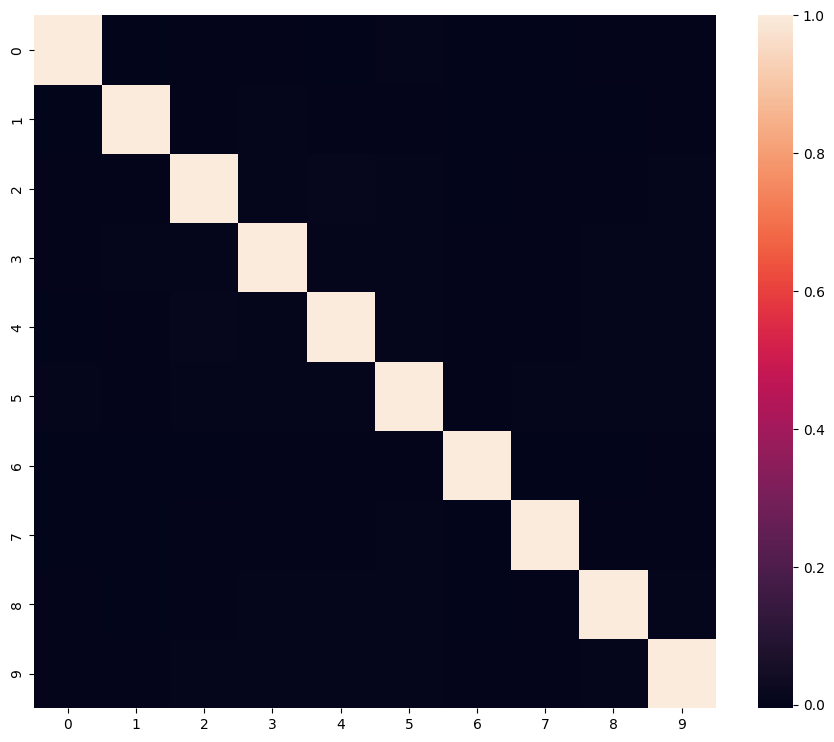

In [27]:
# validation results
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import palettable

plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data=corr_mean,
           )

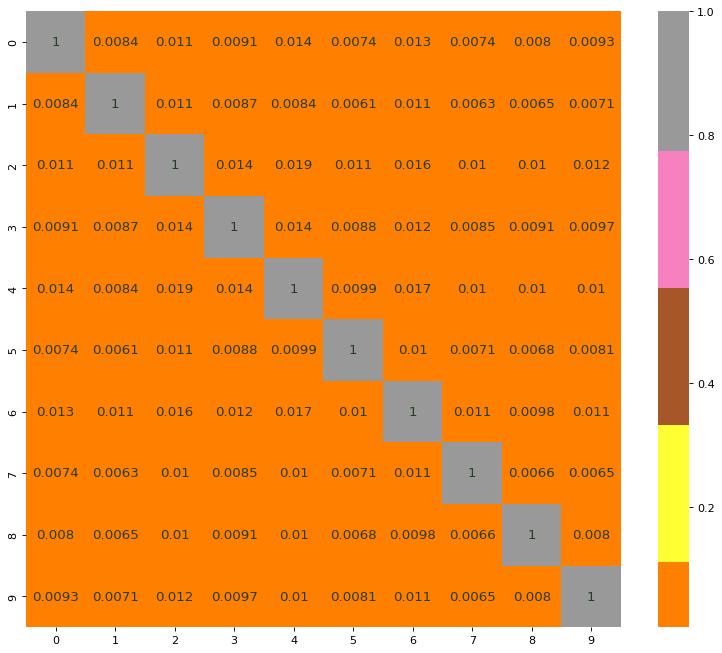

In [28]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    corr_abs_mean,
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

In [29]:
np.sum(corr_abs_mean)-10

0.8990040775388479

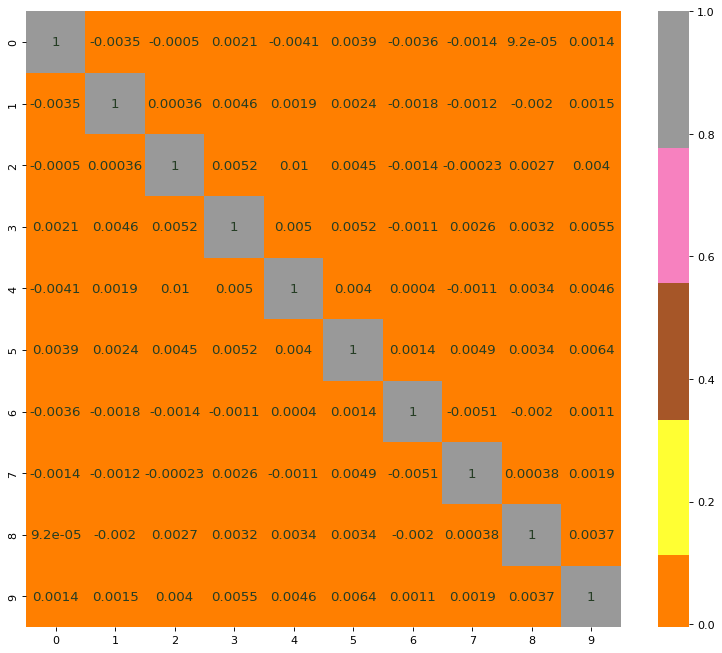

In [30]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    corr_mean,
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

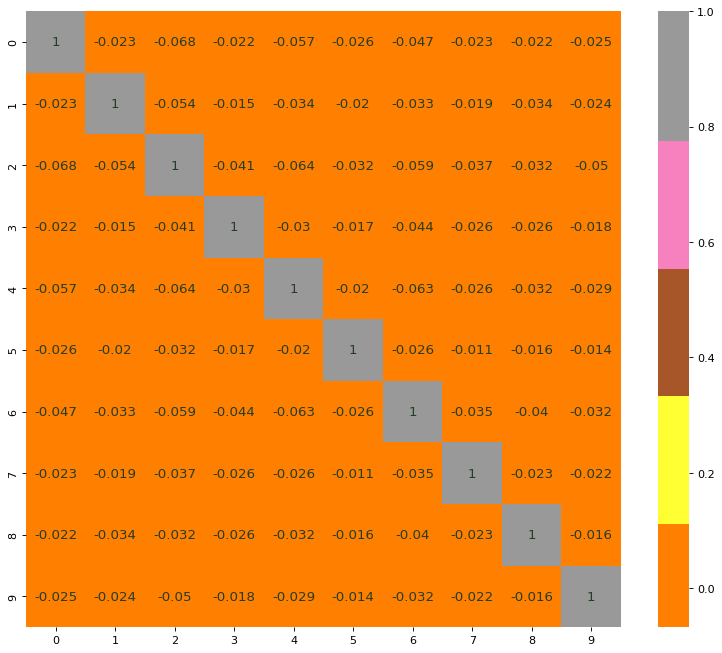

In [31]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    corr_min,
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

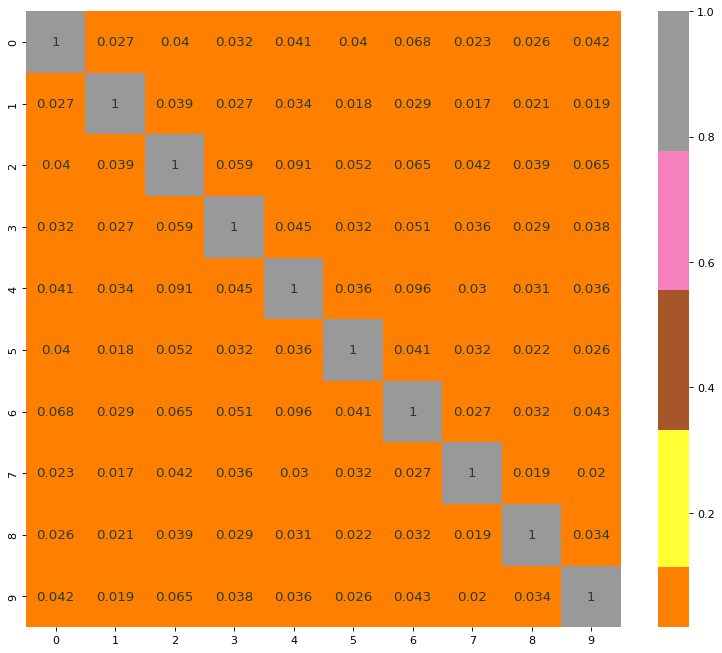

In [32]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    corr_max,
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

In [33]:
np.save('FMNIST-normal-acc-label'+str(LABEL)+'-GridSearch.npy',acc_record)
np.save('FMNIST-normal-radius-label'+str(LABEL)+'-GridSearch.npy',r_records)
np.save('FMNIST-normal-radius2-label'+str(LABEL)+'-GridSearch.npy',r_records2)
np.save('FMNIST-normal-radius-Grid-label'+str(LABEL)+'-GridSearch.npy',r_records_gs)
np.save('FMNIST-normal-radius2-Grid-label'+str(LABEL)+'-GridSearch.npy',r_records_gs2)

np.save('FMNIST-normal-value-Grid-label'+str(LABEL)+'-GridSearch.npy',value_records)
np.save('FMNIST-normal-value2-Grid-label'+str(LABEL)+'-GridSearch.npy',value_records2)
np.save('FMNIST-normal-corr-label'+str(LABEL)+'-GridSearch.npy',corr_whole)
# only need to save because we only train netD
torch.save(netD, 'Final_FMNIST_NetD-label'+str(LABEL)+'-GridSearch.pth')
#torch.save(netV, 'MNIST_NetV-mode1-radius2-makeup.pth')
#torch.save(netG, 'MNIST_NetG-mode1-radius2-makeup.pth')

In [34]:
acc_record

array([[8.60700000e-01, 7.19880000e-01, 7.33285000e-01, 7.58655000e-01,
        7.49140000e-01, 6.46950000e-01, 4.29015000e-01, 2.26820000e-01,
        1.21870000e-01, 1.13000000e-01, 1.07195000e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.60700000e-01, 7.21600000e-01, 7.37600000e-01, 7.62300000e-01,
        7.62300000e-01, 6.79700000e-01, 5.17300000e-01, 2.62500000e-01,
        1.54400000e-01, 1.36100000e-01, 1.52700000e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.60700000e-01, 7.17900000e-01, 7.29300000e-01, 7.54500000e-01,
        7.35400000e-01, 6.11500000e-01, 3.86000000e-01, 1.78700000e-01,
        8.88000000e-02, 8.41000000e-02, 8.06000000e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.0000